In [1]:
import os
# os.environ['TRITON_INTERPRET'] = '1'
from triton_util import *

In [2]:
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

import torch
from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import triton
import triton.language as tl

In [6]:
def copy(x, bs, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)
    n = x.numel()
    n_blocks = cdiv(n, bs)
    grid = (n_blocks,)  # how many blocks do we have? can be 1d/2d/3d-tuple or function returning 1d/2d/3d-tuple
    print(n_blocks)
    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    kernel_fn[grid](x,z,n,bs)

    return z   

In [7]:
@triton.jit
def copy_kernel(x_ptr, z_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = tl.arange(0, bs)
    print(tl.num_programs(0))
    idx = pid * bs + offs
    mask = idx < n
    x = tl.load(x_ptr + idx, mask=mask)
    tl.store(z_ptr + idx, x, mask=mask)
    print_if(f'pid = {pid} | offs = {idx}, mask = {mask}, x = {x}', '')

In [8]:
x = torch.randn(10)
z = copy(x, 4, copy_kernel)

3
[3]
pid = [0] | offs = [0 1 2 3], mask = [ True  True  True  True], x = [-0.3283909  -1.6973063   0.03244857 -0.5468331 ]
[3]
pid = [1] | offs = [4 5 6 7], mask = [ True  True  True  True], x = [-0.3995536   0.10285716  0.09246378  0.66915786]
[3]
pid = [2] | offs = [ 8  9 10 11], mask = [ True  True False False], x = [-2.0501096 -0.9739577  0.         0.       ]


In [21]:
x == z

tensor([True, True, True, True, True, True, True, True, True, True])

In [22]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)

In [23]:
img = io.read_image(str(path_img))
print(img.shape)

torch.Size([3, 1066, 1600])


In [24]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

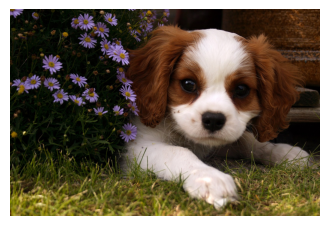

In [25]:
show_img(img)

In [26]:
img = tvf.resize(img, 150, antialias=True)
ch,h,w = img.shape
ch,h,w,h*w

(3, 150, 225, 33750)

In [65]:
@triton.jit
def rgb2grey_kernel(x_ptr, z_ptr, h, w, bs0: tl.constexpr, bs1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    offsets_0 = tl.arange(0, bs0)
    offsets_1 = tl.arange(0, bs1)

    offsets_0 = pid_0 * bs0 + offsets_0
    offsets_1 = pid_1 * bs1 + offsets_1
    
    offsets = w * offsets_0[:, None] + offsets_1[None, :]
    mask_0 = offsets_0 < h
    mask_1 = offsets_1 < w
    mask = mask_0[:, None] & mask_1[None, :]
    r = tl.load(x_ptr + 0 * h * w + offsets, mask=mask)
    g = tl.load(x_ptr + 1 * h * w + offsets, mask=mask)
    b = tl.load(x_ptr + 2 * h * w + offsets, mask=mask)
    print(offsets_0)
    out = 0.2989*r + 0.5870*g + 0.1140*b
    tl.store(z_ptr + offsets, out, mask=mask)

In [66]:
def rgb2grey(x, bs):
    c, h, w = x.shape
    z = torch.zeros((h, w), dtype=x.dtype, device=x.device)
    grid = (cdiv(h, bs), cdiv(w, bs))
    
    rgb2grey_kernel[grid](x, z, h, w, bs, bs)
    return z

In [67]:
grey_img = rgb2grey(img, bs=32)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]
[32 33 34 

In [57]:
grey_img.shape

torch.Size([150, 225])

In [58]:
grey_img.stride(0)

225

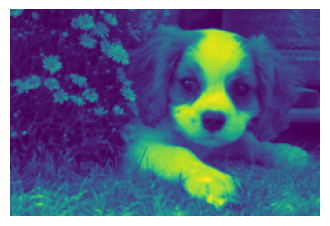

In [50]:
show_img(grey_img)

In [ ]:
@triton.jit
def naive_matmul_kernel(a_ptr, b_ptr, c_ptr, h, w, k, bs: tl.constexpr):
    pid_r = tl.program_id(0)
    pid_c = tl.program_id(1)

    row_idx = pid_r * bs + tl.arange(0, bs)
    col_idx = pid_c * bs + tl.arange(0, bs)
    inner_idx = tl.arange(0, bs)

    offset_a = row_idx[:, None] * h + inner_idx[None, :]
    offset_b = inner_idx[:, None] * w + col_idx[None, :]

    acc = tl.zeros((bs, bs), dtype=tl.float32)
    for _ in range(0, k, bs):
        a = tl.load(a_ptr + offset_a)
        b = tl.load(b_ptr + offset_b)
        acc += tl.dot(a, b, allow_tf32=False)
        offset_a += bs
        offset_b += bs*w
    c = c_ptr + row_idx[:, None] * w + col_idx[None, :]
    mask = (row_idx[:, None] < h) & (col_idx[None, :] < w)
    tl.store(c, acc, mask=mask)

In [75]:
def naive_matmul(a, b, bs):
    h, k = a.shape
    k, w = b.shape
    c = torch.zeros((h, w), device=a.device)
    grid = (cdiv(h, bs), cdiv(w, bs))
    
    naive_matmul_kernel[grid](a, b, c, h, w, k, bs)
    return c

In [76]:
a = torch.randn(512, 512, device='cuda')
b = torch.randn(512, 512, device='cuda')
c = naive_matmul(a, b, bs=32)

CompilationError: at 21:4:
    offset_b = inner_idx[:, None] * w + col_idx[None, :]

    acc = tl.zeros((bs, bs), dtype=tl.float32)
    for _ in range(0, k, bs):
        a = tl.load(a_ptr + offset_a)
        b = tl.load(b_ptr + offset_b)
        acc += tl.dot(a, b, allow_tf32=False)
        offset_a += bs
        offset_b += bs*w
    c = c_ptr + row_idx[:, None] * w + col_idx[None, :]
    mask = (row_idx[:, None] < h) & (col_idx[None, :] < w)
    print(tl.num_programs(0))
    ^

In [ ]:
c.shape

tensor([[ 29.3417,   0.5487,  16.3702,  ...,  -7.4716, -10.4118,  19.6373],
        [ 16.5035,  38.3299,  -4.7732,  ...,  37.7510,  13.4070,  14.0785],
        [-22.2287, -32.6944, -16.3021,  ..., -14.9302, -16.4444,  14.5666],
        ...,
        [-12.8522,  -4.3040,  36.5459,  ..., -41.1592,   1.9917,  23.7303],
        [ -0.2925, -14.8211, -10.3034,  ...,   0.7059, -13.7577, -33.9875],
        [-19.3852,  23.5308,  -0.7615,  ..., -21.1682,   2.5721, -33.9890]],
       device='cuda:0')

In [61]:
c2 = a@b

In [ ]:
torch.isclose(c, c2, atol=1e-4).all()

tensor(True, device='cuda:0')

In [1]:
# import os
# os.environ['TRITON_INTERPRET'] = '1'

import torch

import triton
import triton.language as tl

from triton.runtime import driver

# DEVICE = triton.runtime.driver.active.get_active_torch_device()


In [2]:
target = driver.active.get_current_target()
backend = target.backend
arch = target.arch
warp_size = target.warp_size

In [3]:
properties = driver.active.utils.get_device_properties(0)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
kernels = {}

In [4]:
def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"

def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')

In [5]:
BLOCK_SIZE = 2048

In [6]:
def cdiv(a,b): return (a + b - 1) // b

In [7]:
@triton.jit
def softmax_kernel(input_ptr, output_ptr, n_row, n_class, bs: tl.constexpr):
    pid = tl.program_id(0)
    row_idx = pid * n_class

    max_val = float('-inf')
    denominator = 0.0
    # print(row_idx + tl.arange(0, bs))
    for i in range(0, n_class, bs):
        col_idx = i + tl.arange(0, bs)
        mask =  col_idx < n_class
        idx = row_idx + col_idx
        x = tl.load(input_ptr + idx, mask=mask)
        max_val = tl.maximum(max_val, tl.max(x))
    # max_val = tl.broadcast(max_val, n_class)
    for i in range(0, n_class, bs):
        col_idx = i + tl.arange(0, bs)
        mask =  col_idx < n_class
        idx = row_idx + col_idx
        x = tl.load(input_ptr + idx, mask=mask)
        x = tl.exp(x - max_val)
        denominator += tl.sum(tl.where(mask, x, 0.0))
        tl.store(output_ptr + idx, x, mask=mask)
    # denominator = tl.broadcast(denominator, n_class)
    for i in range(0, n_class, bs):
        col_idx = i + tl.arange(0, bs)
        mask =  col_idx < n_class
        idx = row_idx + col_idx
        x = tl.load(output_ptr + idx, mask=mask)
        x /= denominator
        tl.store(output_ptr + idx, x, mask=mask)
    


In [8]:
def softmax(x):
    n_row, n_class = x.shape
    y = torch.zeros_like(x)
    softmax_kernel[(n_row, )](x, y, n_row, n_class, BLOCK_SIZE)
    return y

In [9]:
x = torch.randn(512, 2049, device='cuda')

In [11]:
%%timeit
softmax(x).sum(-1)

24.3 μs ± 39.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit
torch.nn.functional.softmax(x, dim=-1).sum(-1)

35.9 μs ± 2.18 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
def test_softmax(atol=1e-4, device="cuda"):
    x = torch.randn(512, 1024, device=device)
    y = x.softmax(dim=-1)
    

In [7]:
x = torch.randn(512, 1024, device='cuda')

In [10]:
softmax(x)

TypeError: softmax_kernel() missing 1 required positional argument: 'num_stages'